# Compute transformation due to surface fluxes from MERRA data 
> [Summary page](https://disc.gsfc.nasa.gov/datasets/M2T1NXOCN_5.12.4/summary)

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask
import dask.array as dsa
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
import pandas as pd

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean.zarr'))
rad = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/rad.zarr'))

In [3]:
ds

<xarray.Dataset> Size: 125MB
Dimensions:   (time: 7296, lat: 19, lon: 45)
Coordinates:
  * lat       (lat) float64 152B 22.0 22.5 23.0 23.5 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time      (time) datetime64[ns] 58kB 2023-01-01T00:30:00 ... 2023-10-31T2...
Data variables:
    EFLUXWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    HFLUXWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    LWGNTWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    SWGNTWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    TSKINWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/Y67YQ1L3ZZ4R
    identifier_product_doi_authority:  http://dx.doi.org/

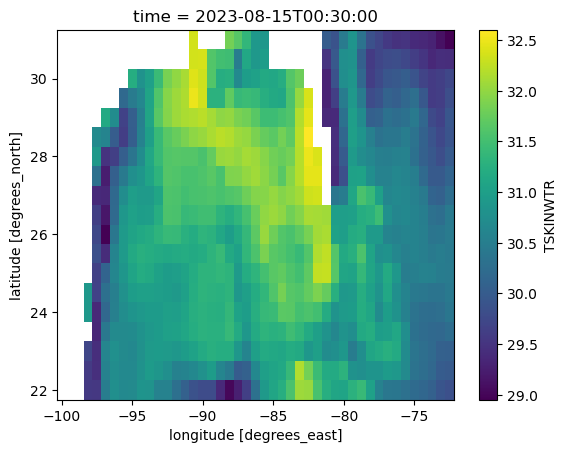

In [4]:
(ds.TSKINWTR-273.15).sel(time='2023-08-15', method='nearest').plot()

## Create grid and area objects

In [5]:
ds_full = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'})

In [6]:
ds_full

<xarray.Dataset> Size: 125MB
Dimensions:   (time: 7296, lat: 19, lon: 45, lon_left: 45, lat_left: 19)
Coordinates:
  * lat       (lat) float64 152B 22.0 22.5 23.0 23.5 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time      (time) datetime64[ns] 58kB 2023-01-01T00:30:00 ... 2023-10-31T2...
  * lon_left  (lon_left) float64 360B -100.3 -99.69 -99.06 ... -73.44 -72.81
  * lat_left  (lat_left) float64 152B 21.75 22.25 22.75 ... 29.75 30.25 30.75
Data variables:
    EFLUXWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    HFLUXWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    LWGNTWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    SWGNTWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    TSKINWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/Y67YQ1L3ZZ4R
    identifier_product_doi_authority:  http://dx.doi.org/

In [7]:
grid = xgcm.Grid(ds_full, periodic=['X'])
grid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   lat --> left
  * left     lat_left --> center
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_left --> center
T Axis (not periodic, boundary=None):
  * center   time

In [8]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'], 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'], 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'], 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}']))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'], 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left']))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [9]:
cell_elements = deg_2_m(grid, ds_full, 'lat', 'lon')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [10]:
cell_elements.dx_l

<xarray.DataArray 'dx_l' (lon: 45, lat_left: 19)> Size: 7kB
array([[   64549.31881147,    64322.13028175,    64090.04337277,
           63853.07575886,    63611.24548601,    63364.57097053,
           63113.07099765,    62856.76472006,    62595.67165647,
           62329.81169014,    62059.20506734,    61783.87239579,
           61503.83464315,    61219.11313539,    60929.72955514,
           60635.70594008,    60337.06468126,    60033.82852136,
           59726.02055298],
       [   64549.31881147,    64322.13028175,    64090.04337277,
           63853.07575886,    63611.24548601,    63364.57097053,
           63113.07099765,    62856.76472006,    62595.67165647,
           62329.81169014,    62059.20506734,    61783.87239579,
           61503.83464315,    61219.11313539,    60929.72955514,
           60635.70594008,    60337.06468126,    60033.82852136,
           59726.02055298],
       [   64549.31881147,    64322.13028175,    64090.04337277,
           63853.07575886,    63611.24548601,    63364.57097053,
           63113.07099765,    62856.76472006,    62595.67165647,
           62329.81169014,    62059.20506734,    61783.87239579,
           61503.83464315,    61219.11313539,    60929.72955514,
           60635.70594008,    60337.06468126,    60033.82852136,
...
           63853.07575886,    63611.24548601,    63364.57097053,
           63113.07099765,    62856.76472006,    62595.67165647,
           62329.81169014,    62059.20506734,    61783.87239579,
           61503.83464315,    61219.11313539,    60929.72955514,
           60635.70594008,    60337.06468126,    60033.82852136,
           59726.02055298],
       [   64549.31881147,    64322.13028175,    64090.04337277,
           63853.07575886,    63611.24548601,    63364.57097053,
           63113.07099765,    62856.76472006,    62595.67165647,
           62329.81169014,    62059.20506734,    61783.87239579,
           61503.83464315,    61219.11313539,    60929.72955514,
           60635.70594008,    60337.06468126,    60033.82852136,
           59726.02055298],
       [-2840170.02770487, -2830173.73239703, -2819961.90840201,
        -2809535.33338973, -2798894.80138426, -2788041.1227033 ,
        -2776975.12389651, -2765697.64768253, -2754209.55288485,
        -2742511.71436637, -2730605.02296277, -2718490.3854147 ,
        -2706168.72429872, -2693640.97795702, -2680908.100426  ,
        -2667971.06136358, -2654830.84597536, -2641488.45493962,
        -2627944.90433111]])
Coordinates:
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * lat_left  (lat_left) float64 152B 21.75 22.25 22.75 ... 29.75 30.25 30.75

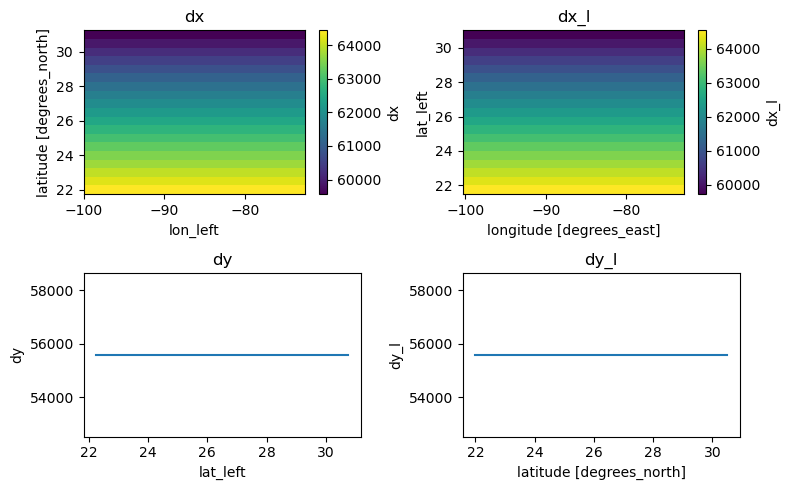

In [11]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements.dx[1:].T.plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements.dx_l[:-1].T.plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

# Run histogram

In [12]:
dx_interp = grid.interp(cell_elements.dx_l, 'Y')
area = dx_interp * cell_elements.dy_l#[1:]

In [13]:
cell_elements.dx_l.coords

Coordinates:
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * lat_left  (lat_left) float64 152B 21.75 22.25 22.75 ... 29.75 30.25 30.75

In [14]:
cell_elements.dy_l.coords

Coordinates:
  * lat      (lat) float64 152B 22.0 22.5 23.0 23.5 24.0 ... 29.5 30.0 30.5 31.0

In [15]:
dx_interp.coords

Coordinates:
  * lat      (lat) float64 152B 22.0 22.5 23.0 23.5 24.0 ... 29.5 30.0 30.5 31.0
  * lon      (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5

In [16]:
area[:-1].coords

Coordinates:
  * lat      (lat) float64 152B 22.0 22.5 23.0 23.5 24.0 ... 29.5 30.0 30.5 31.0
  * lon      (lon) float64 352B -100.0 -99.38 -98.75 ... -74.38 -73.75 -73.12

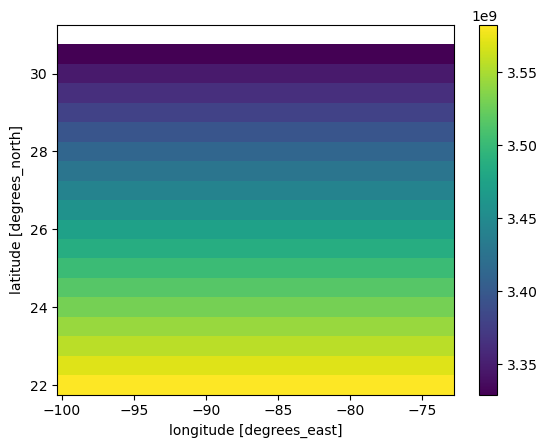

In [17]:
area[:-1].T.plot()

In [18]:
np.diff(ds.time)/1e9

array([3600, 3600, 3600, ..., 3600, 3600, 3600], dtype='timedelta64[ns]')

In [19]:
ds_r = ds.resample(time='D').mean()

In [20]:
np.diff(ds_r.time)/1e9

array([86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400,

In [21]:
area.coords

Coordinates:
  * lat      (lat) float64 152B 22.0 22.5 23.0 23.5 24.0 ... 29.5 30.0 30.5 31.0
  * lon      (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5

In [22]:
ds_r.coords

Coordinates:
  * lat      (lat) float64 152B 22.0 22.5 23.0 23.5 24.0 ... 29.5 30.0 30.5 31.0
  * lon      (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time     (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-10-31

In [23]:
Cp = heat_capacity_cp = 3.994e3 #J/kg/˚C
rho = 1034 #kg/m^3

#var (W/m^2) x 1/Cp x area x 1/rho
ds_weighted = ds_r * area * (1/Cp) * (1/rho) #˚C m^3/s

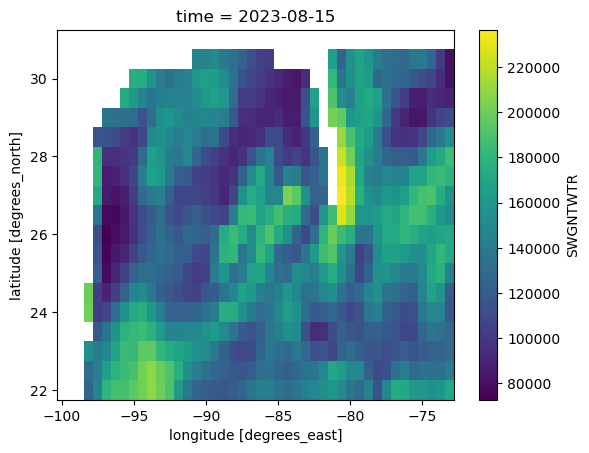

In [24]:
ds_weighted.SWGNTWTR.sel(time='2023-08-15', method='nearest').isel(lon=slice(None, -1)).plot()

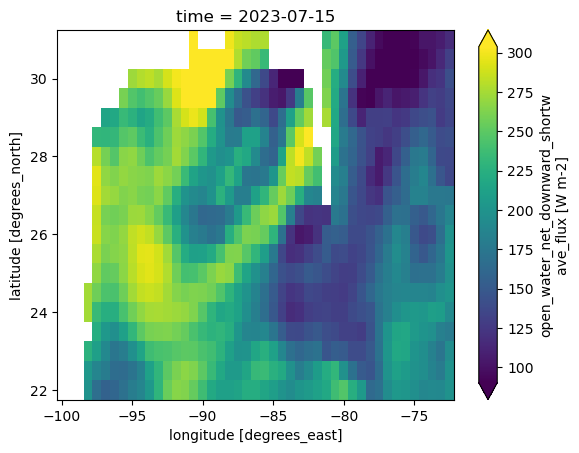

In [25]:
ds_r.SWGNTWTR.sel(time='2023-07-15', method='nearest').plot(robust=True)

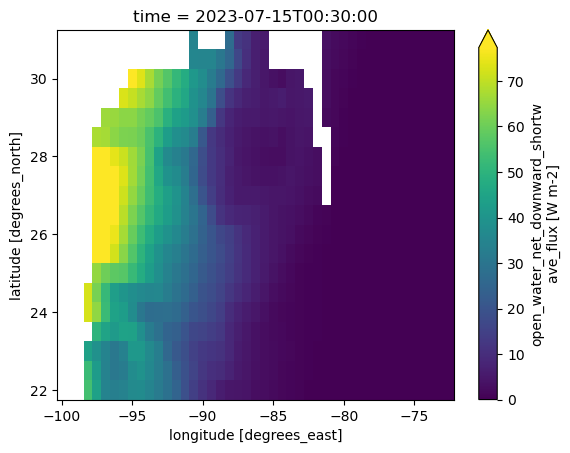

In [26]:
ds.SWGNTWTR.sel(time='2023-07-15', method='nearest').plot(robust=True)

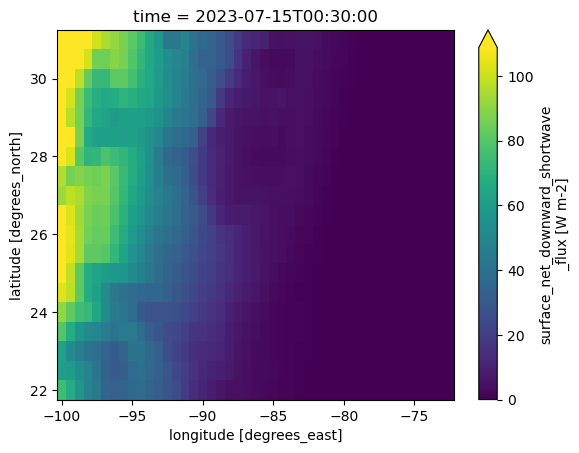

In [27]:
rad.SWGNT.sel(time='2023-07-15', method='nearest').plot(robust=True)

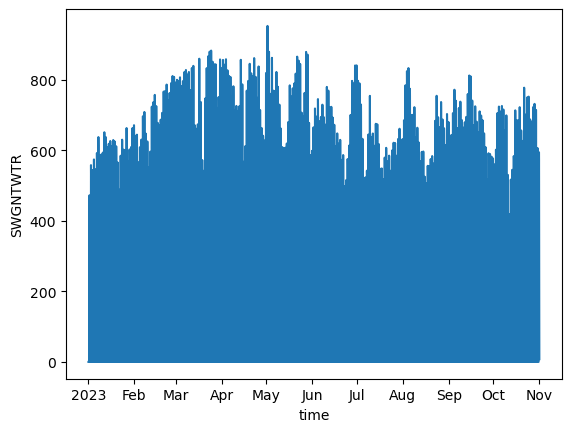

In [28]:
ds.SWGNTWTR.mean(['lat', 'lon']).plot()

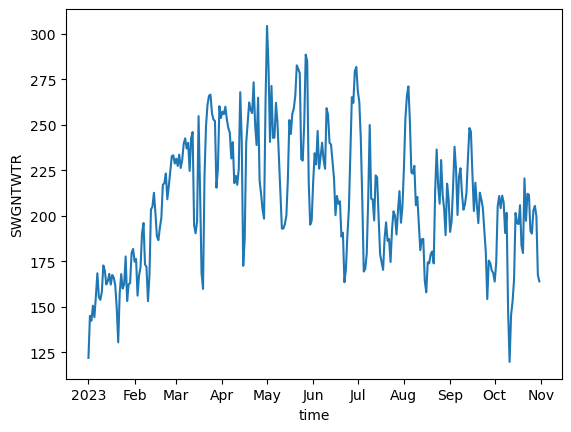

In [29]:
ds_r.SWGNTWTR.mean(['lat', 'lon']).plot()

In [43]:
delta_theta = 0.1
theta_bins = np.arange(20,34,delta_theta)
sst = (ds_r.TSKINWTR-273.15).isel(lon=slice(None, -1))

def hist_func(ds, variable):
    hist = histogram(sst.rename('theta'), bins=[theta_bins],
                    weights=(ds[variable]).fillna(0.),
                    dim=['lon', 'lat']) / delta_theta
    return hist #m^3/s (Sv)

In [44]:
sst.coords

Coordinates:
  * lat      (lat) float64 152B 22.0 22.5 23.0 23.5 24.0 ... 29.5 30.0 30.5 31.0
  * lon      (lon) float64 352B -100.0 -99.38 -98.75 ... -74.38 -73.75 -73.12
  * time     (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-10-31

In [45]:
ds_weighted.isel(lon=slice(None, -1)).coords

Coordinates:
  * lat      (lat) float64 152B 22.0 22.5 23.0 23.5 24.0 ... 29.5 30.0 30.5 31.0
  * lon      (lon) float64 352B -100.0 -99.38 -98.75 ... -74.38 -73.75 -73.12
  * time     (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-10-31

In [46]:
hist = xr.merge([hist_func(ds_weighted.isel(lon=slice(None, -1)), var).rename('omega_' + var) 
                      for var in list(ds_weighted)[:-1]])

In [47]:
hist

<xarray.Dataset> Size: 1MB
Dimensions:         (time: 304, theta_bin: 139)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2023-01-01 ... 2023-10-31
  * theta_bin       (theta_bin) float64 1kB 20.05 20.15 20.25 ... 33.75 33.85
Data variables:
    omega_EFLUXWTR  (time, theta_bin) float64 338kB dask.array<chunksize=(1, 139), meta=np.ndarray>
    omega_HFLUXWTR  (time, theta_bin) float64 338kB dask.array<chunksize=(1, 139), meta=np.ndarray>
    omega_LWGNTWTR  (time, theta_bin) float64 338kB dask.array<chunksize=(1, 139), meta=np.ndarray>
    omega_SWGNTWTR  (time, theta_bin) float64 338kB dask.array<chunksize=(1, 139), meta=np.ndarray>

In [56]:
one_plt = hist.sel(theta_bin=31.8, method='nearest')

In [57]:
one_plt

<xarray.Dataset> Size: 12kB
Dimensions:         (time: 304)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2023-01-01 ... 2023-10-31
    theta_bin       float64 8B 31.75
Data variables:
    omega_EFLUXWTR  (time) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    omega_HFLUXWTR  (time) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    omega_LWGNTWTR  (time) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    omega_SWGNTWTR  (time) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>

In [40]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
#options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(15)
client = cluster.get_client()

In [41]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.6a8e8b742c1d4fb39b1071e7cc337eaf/status,


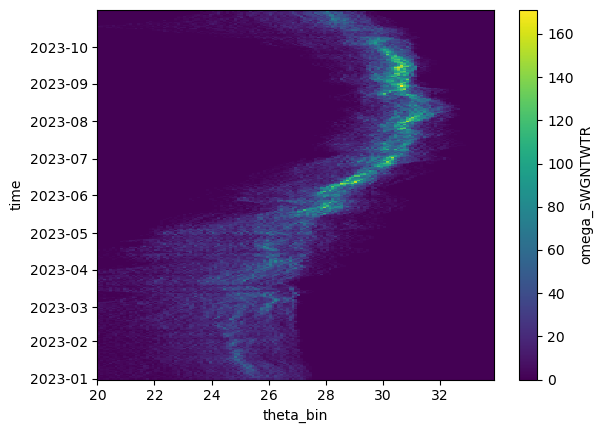

In [58]:
(hist.omega_SWGNTWTR/1e6).plot()

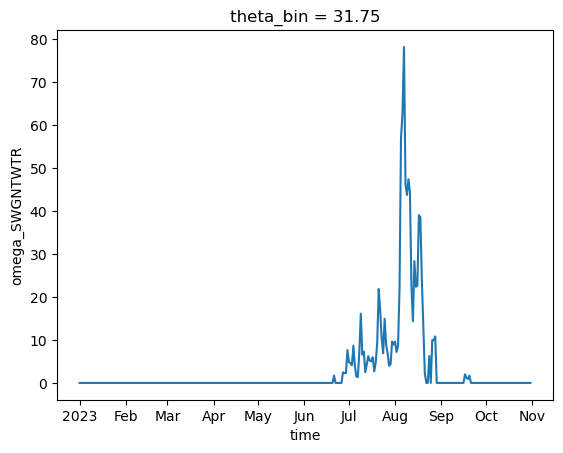

In [51]:
(hist.omega_SWGNTWTR/1e6).sel(theta_bin=31.8, method='nearest').plot()

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 9.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


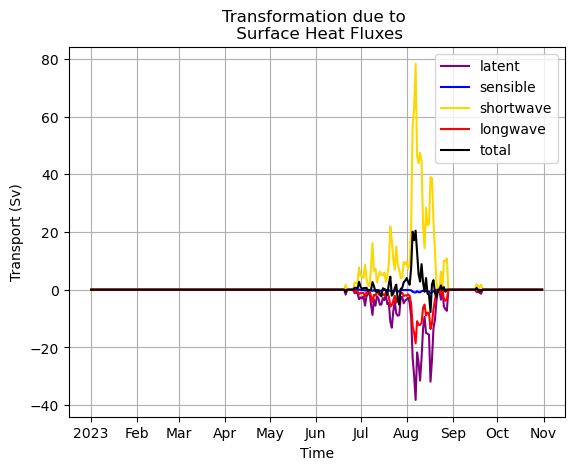

In [59]:
#merra2 surf data
(-one_plt.omega_EFLUXWTR/1e6).plot(label='latent', color='purple')
(-one_plt.omega_HFLUXWTR/1e6).plot(label='sensible', color='blue')
(one_plt.omega_SWGNTWTR/1e6).plot(label='shortwave', color='gold')
(one_plt.omega_LWGNTWTR/1e6).plot(label='longwave', color='r')
#(one_plt_merra/1e6).to_array().sum('variable').plot(label='total', color='k')
((-one_plt.omega_HFLUXWTR-one_plt.omega_EFLUXWTR+
  one_plt.omega_LWGNTWTR+one_plt.omega_SWGNTWTR)/1e6).plot(label='total', color='k')
plt.grid()
plt.legend()
plt.title('Transformation due to \n Surface Heat Fluxes')
plt.ylabel('Transport (Sv)')
plt.xlabel('Time');